---
# Comparison partial FOV pRF with Whole-Brain pRF

This notebook shows the pRF-analysis of the partial FOV acquired while registering the lowres anatomical scan to the session 1 anatomy. The experiment consisted of 1 iteration of the lineprf2 experiment, with 2 bar thicknesses (thin/thick) and 4 motion directions (Left-right, right-left, up-down, down-up); total = 8 bar configurations. 

The goals of the notebook are as follows:
- Create design matrix where stimulus duration (0.25s) < TR (1.1s) - the line experiment will follow a similar strategy
- Implement pRF-analyses as classes
- Compare pRF estimates obtained during linescanning session with pRF+anatomy session

## Registration workflow

go to directory: `cd /data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf`

1) Apply the inverse of `from-fs_to_ses?_desc-genaff`-matrix to the functional data; this brings the functional data in FreeSurfer space: `call_antsapplytransforms -i 1 -t lin /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/freesurfer/sub-003/mri/orig.nii.gz sub-003_ses-3_task-pRF_acq-3DEPI_run-1_bold.nii.gz sub-003_ses-3_task-pRF_acq-3DEPI_run-2_bold.nii.gz /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/pycortex/sub-003/transforms/sub-003_from-fs_to-ses3_desc-genaff.mat`

2) Make a FreeSurfer-compatible `.dat`-registration matrix: `call_createident -s sub-003 ident.dat sub-003_ses-3_task-pRF_acq-3DEPI_run-2_bold.nii.gz`

3) Warp to fsnative/fsaverage: `call_vol2fsaverage -r ident.dat -o $PWD -p sub-003_ses-3_task-pRF sub-003 sub-003_ses-3_task-pRF_acq-3DEPI_run-2_bold.nii.gz run-2_bold.func`. This calls `call_stackgiftis` and `call_giftimeta` internally, creating `.gii`-files with the TR in the metadata, and the `.npy`-output like `pybest` would give

In [22]:
from IPython.display import Image
%reload_ext autoreload
%autoreload 2

import numpy as np
from linescanning import utils,glm,prf
import matplotlib.pyplot as plt
import os
import warnings
from scipy.io import loadmat
from nilearn import signal
from nilearn.glm.first_level.design_matrix import _cosine_drift as dct_set

warnings.simplefilter('ignore')

opj = os.path.join
base = os.environ['DIR_PROJECTS']

base_dir = opj(base, 'hemifield')
fig_dir = opj(base_dir, 'code', 'figures', 'prf')
task_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sourcedata/sub-003/ses-3/task/sub-003_ses-3_run-1_task-PRF"
func_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf"
print(base_dir)


/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield


### Fetch the onsets of pRF-experiment

In [2]:
# load onsets
onsets = utils.ParseExpToolsFile(utils.get_file_from_substring(".tsv", task_dir), TR=1.111508, delete_vols=0)
trial_df = onsets.get_onset_df()
print(f"TR = {onsets.TR}")
trial_df.tail(20)

TR = 1.111508


,onset,event_type,subject,run
500,175.471935,vertical,1,1
501,175.541486,vertical,1,1
502,175.858221,vertical,1,1
503,176.166634,vertical,1,1
504,176.483204,vertical,1,1
505,176.799868,vertical,1,1
506,177.116627,vertical,1,1
507,177.433194,vertical,1,1
508,177.741504,vertical,1,1
509,178.058231,vertical,1,1


### Fetch the functional data; apply high-pass filter + zscore data

Load data, apply highpass filtering in the form of discrete cosine set

(314134, 200)
(314134, 200)


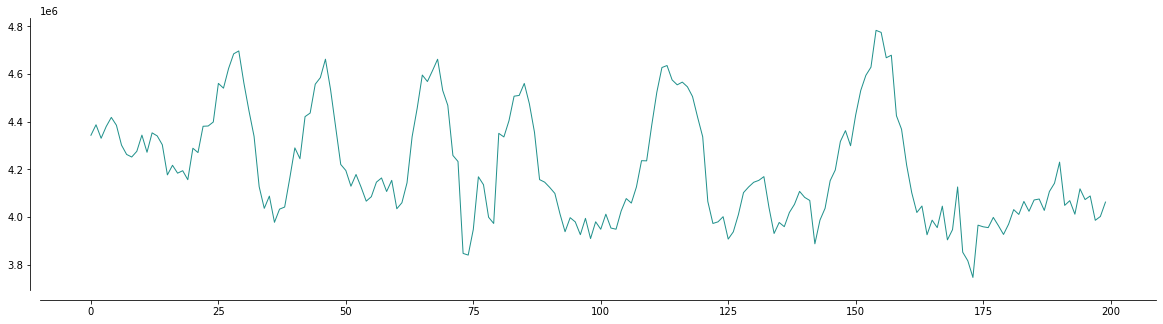

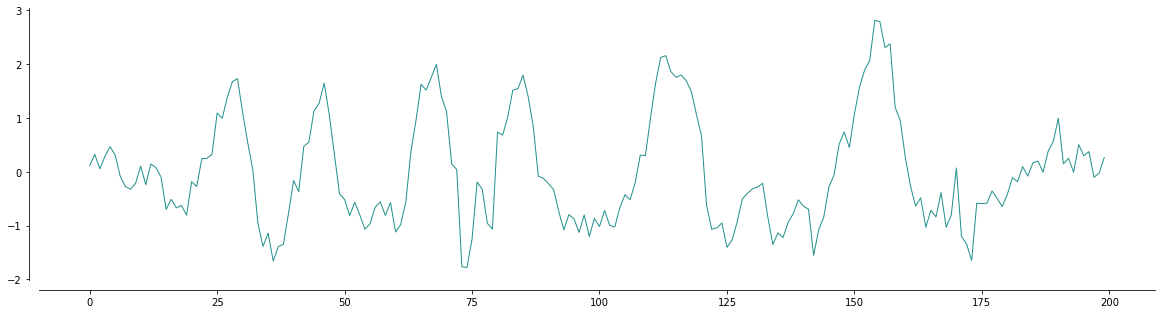

In [3]:
# load functional data
func_data = np.load(utils.get_file_from_substring("sub-003_ses-3_task-pRF_hemi-LR_space-fsnative_run-2_bold.func.npy", func_dir))

print(func_data.shape)

lb=0.01
n_vol = func_data.shape[-1]
st_ref = 0  # offset frametimes by st_ref * tr

# define discrete cosine
ft = np.linspace(st_ref * onsets.TR, (n_vol + st_ref) * onsets.TR, n_vol, endpoint=False)
hp_set = dct_set(lb, ft)
func_cleaned = signal.clean(func_data.T, detrend=False, standardize='zscore', confounds=hp_set).T

print(func_cleaned.shape)

utils.LazyPlot(func_data[336,...], figsize=(20,5))
utils.LazyPlot(func_cleaned[336,...], figsize=(20,5))

### Create design matrix for partial FOV experiment

Here, I chose to select the image in the middle of a given TR. This is because every TR the bar would move 4-5 places (TR = 1.1s, bar duration = 0.25s). So I loop through the TRs, add 0.5*TR, and find the closest value of that in the onset file of the experiment. You can then load in the appropriate screenshot based on the trial number that's coupled to the onset time.

(270, 270, 200)


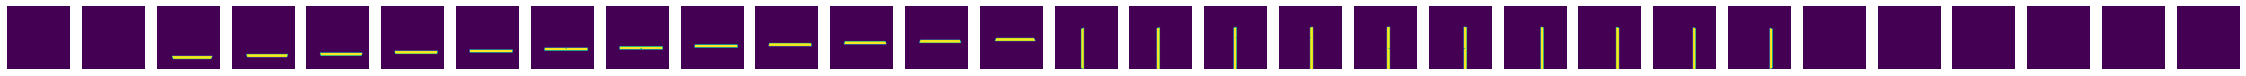

In [4]:
design_matrix = prf.create_line_prf_matrix(task_dir, 
                                           stim_duration=0.25, 
                                           nr_trs=func_data.shape[-1],
                                           n_pix=270,
                                           stim_at_half_TR=True,
                                           deleted_first_timepoints=0,
                                           deleted_last_timepoints=0,
                                           TR=onsets.TR,
                                           skip_first_img=False)

print(design_matrix.shape)

nr_plots = 30
start = 20

f, ss = plt.subplots(1,nr_plots,figsize=(40,7))
# ss[0].imshow(design_matrix['stim'].T[20])

for x in range(start,start+nr_plots):
    ss[x-start].imshow(design_matrix[...,x])
    ss[x-start].axis('off')

I converted most of the pRF-stuff to classes. For this, I needed the repetition time. However, pybest outputs its denoised files in numpy-format, so I had to find another way of getting the TR. fMRIprep stores the TR in the gii-files as metadata. Given that I converted the functional data for this experiment to surface files myself (see `Registration workflow` above), this didn't happen at first. So I wrote some functions that do these operations for me. Below you can see it indeed now has the TR in the gifti metadata

In [5]:
gii_file = utils.get_file_from_substring("sub-003_ses-3_task-pRF_hemi-L_space-fsnative_run-3_bold.func.gii", func_dir)
print(gii_file)
gifti = utils.ParseGiftiFile(gii_file)
gifti.__dict__

/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/sub-003_ses-3_task-pRF_hemi-L_space-fsnative_run-3_bold.func.gii


{'gifti_file': '/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/sub-003_ses-3_task-pRF_hemi-L_space-fsnative_run-3_bold.func.gii',
 'f_gif': <nibabel.gifti.gifti.GiftiImage at 0x7f309751f3d0>,
 'data': array([[2690771.2, 2896243.2, 1578017.2, ...,       0. ,       0. ,
               0. ],
        [3120036.8, 3345314.2, 1911971.4, ...,       0. ,       0. ,
               0. ],
        [2900508.8, 3196758.8, 1880346.9, ...,       0. ,       0. ,
               0. ],
        ...,
        [2871641.5, 2796760.5, 2329286.2, ...,       0. ,       0. ,
               0. ],
        [2547122. , 2734521. , 2313736.5, ...,       0. ,       0. ,
               0. ],
        [2709133.2, 2874805.8, 2217690. , ...,       0. ,       0. ,
               0. ]], dtype=float32),
 'set_tr': None,
 'meta': {'TimeStep': '1111.0'},
 'TR_ms': 1111.0,
 'TR_sec': 1.111}

### pRF fitting

Do everything in the pRFmodelFitting class

In [11]:
from linescanning.prf import pRFmodelFitting

fov_prf = opj(func_dir, "sub-003_ses-3_task-pRF_model-gauss_stage-grid_desc-prf_params.npy")
if not os.path.exists(fov_prf):
    modelling = pRFmodelFitting(func_cleaned, 
                                design_matrix=design_matrix, 
                                TR=gifti.TR_sec, 
                                model='gauss', 
                                stage='grid', 
                                verbose=True, 
                                output_dir=func_dir,
                                output_base="sub-003_ses-3_task-pRF",
                                write_files=True)

    modelling.fit()
else:
    modelling = prf.pRFmodelFitting(func_cleaned,
                                    design_matrix=design_matrix,
                                    settings=opj(func_dir, "20220111_model-gauss_desc-settings.yml"))

    modelling.load_params(fov_prf, stage='grid')

Using settings file: /data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/20220111_model-gauss_desc-settings.yml


In [13]:
best_prf_idc = utils.find_max_val(modelling.gauss_grid[...,-1])
vox = best_prf_idc[0]
params = modelling.gauss_grid[best_prf_idc,...][0]
print(f"best voxel = {vox}; params = {params}")

best voxel = 336; params = [ 1.669 -5.136  0.439  0.014 -0.399  0.671]


load in the pRF-parameters from the Gaussian grid fit from the whole-brain experiment. We can sort of use the same class for this, but it'll have less information (no clear info regarding the grids, though this is present in the settings file). It will have the data-/gauss_grid attribute

In [14]:
prf_dir             = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-1"
whole_brain_prf     = opj(prf_dir, "sub-003_ses-1_task-2R_model-gauss_stage-grid_desc-prf_params.npy")
whole_brain_func    = np.load(opj(prf_dir, "sub-003_ses-1_task-2R_desc-avg_bold_hemi-LR.npy"))
design_matrix       = loadmat(opj(prf_dir, "vis_design.mat"))['stim']
fn_settings         = opj(prf_dir, "20211222_model-gauss_desc-settings.yml")

modelling2 = prf.pRFmodelFitting(whole_brain_func,
                                 design_matrix=design_matrix,
                                 settings=fn_settings)

modelling2.load_params(whole_brain_prf, stage='grid')

Using settings file: /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-1/20211222_model-gauss_desc-settings.yml


### Find pRF in whole-brain experiment that matches pRF in partial FOV experiment

Using the function `prf.find_most_similar_prf`, we can look for pRFs with similar characteristics as a reference pRF in a separate acquisition. Here, we will use the pRF obtained in the linescanning session, and find which vertex in session 1 had these characteristics.

The idea of the function is as follows:

1.) Look for indices where the `x-parameter` is as similar as possible

2.) Filter the main array such that only the parameters of these indices remain

3.) Look for indices where the `y-parameter` is as similar as possible

4.) Filter the main array such that only the parameters of these indices remain

5.) Look for indices where the `size-parameter` is as similar as possible

6.) Filter the main array such that only the parameters of these indices remain

7.) If applicable: apply r2-threshold to remaining vertices

Then, use `utils.find_max_val` to fetch the parameters with the highest r2

In partial FOV experiment, pRF vox = 336
In whole brain experiment, pRF vox = 234


array([ 1.669, -5.136,  0.439,  0.   , -0.164,  0.715])

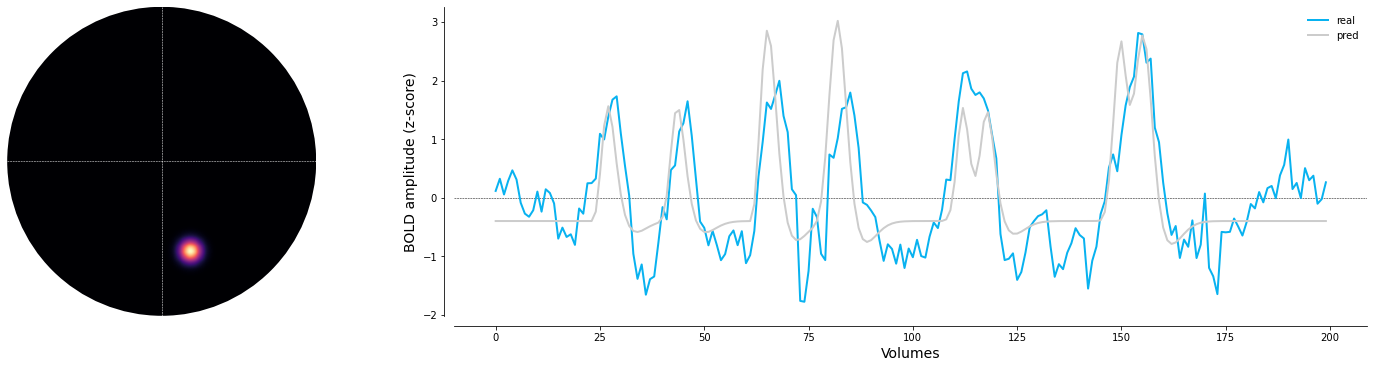

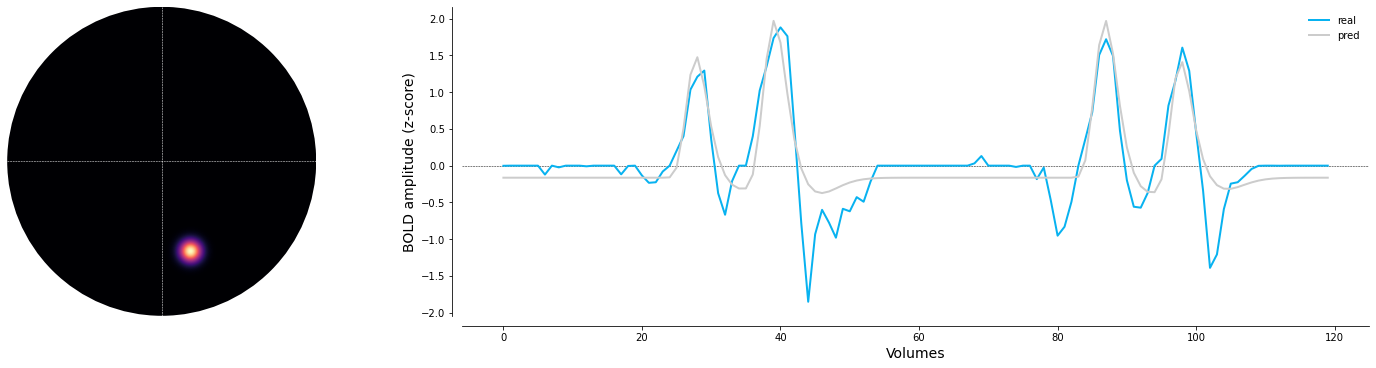

In [15]:
idc_similar_prfs = prf.find_most_similar_prf(params, modelling2.gauss_grid, r2_thresh=0.5)
idx_max_r2 = utils.find_max_val(modelling2.gauss_grid[idc_similar_prfs][:,-1])[0]

print(f"In partial FOV experiment, pRF vox = {vox}")
modelling.plot_vox(vox_nr=vox, stage='grid')

print(f"In whole brain experiment, pRF vox = {idc_similar_prfs[idx_max_r2]}")
modelling2.plot_vox(vox_nr=idc_similar_prfs[idx_max_r2], stage='grid')

This suggests that the two experiments elicit incongruent responses; we'd expect that if we're targeting vertex 1837 based on experiment 1, we retrieve those parameters in experiment 1. Rather, the pRF that was assigned to vertex 1387 is assigned to vertex 336 in experiment 2..

pRF location in partial FOV experiment


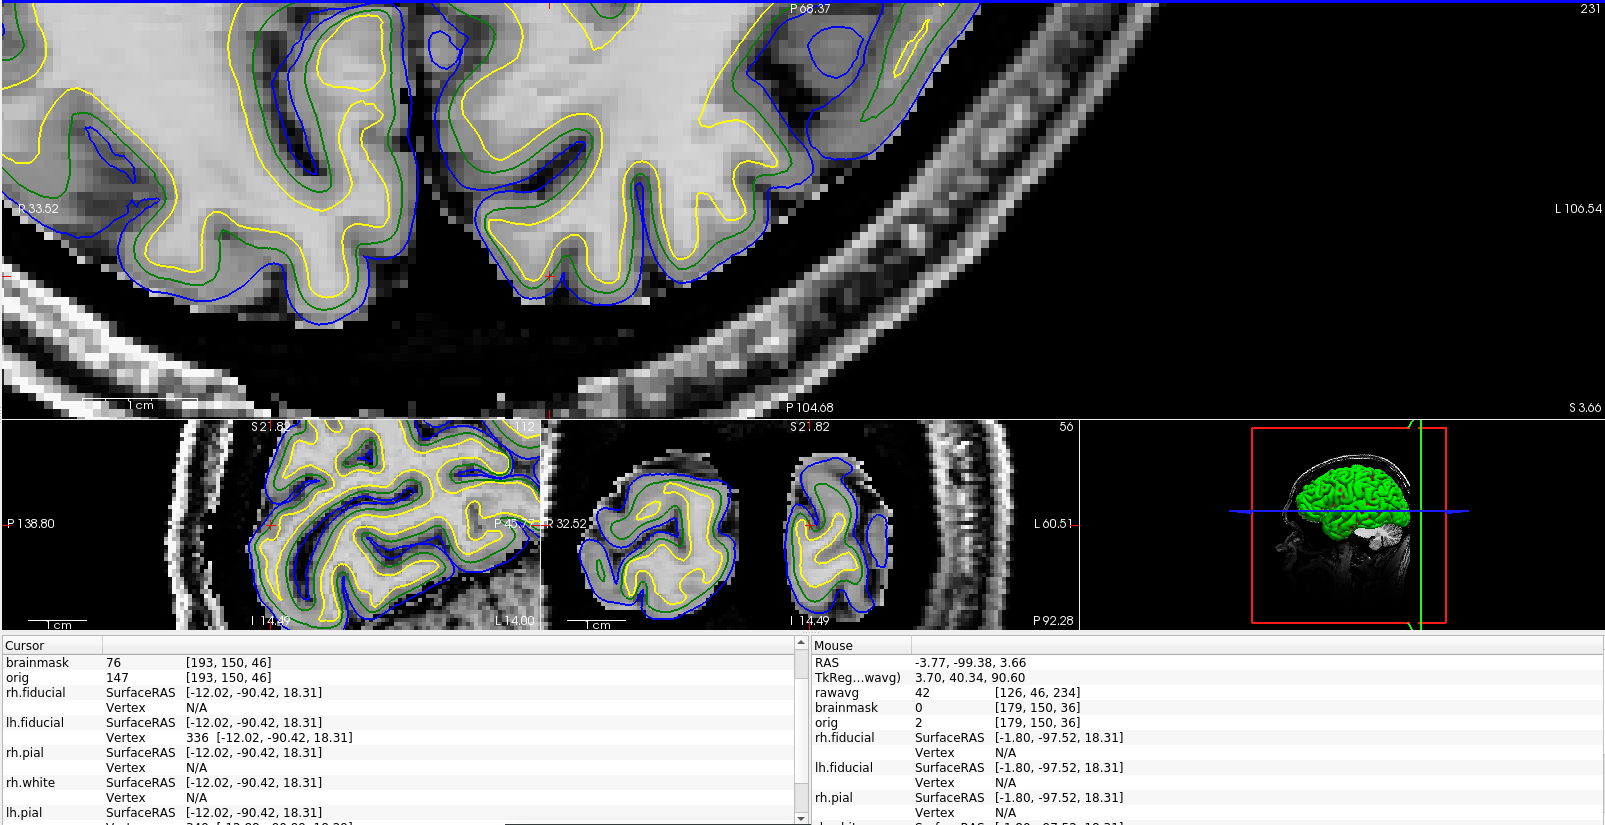

In [17]:
print("pRF location in partial FOV experiment")
Image(filename="imgs/336.png")

pRF location in whole-brain experiment (session 1)


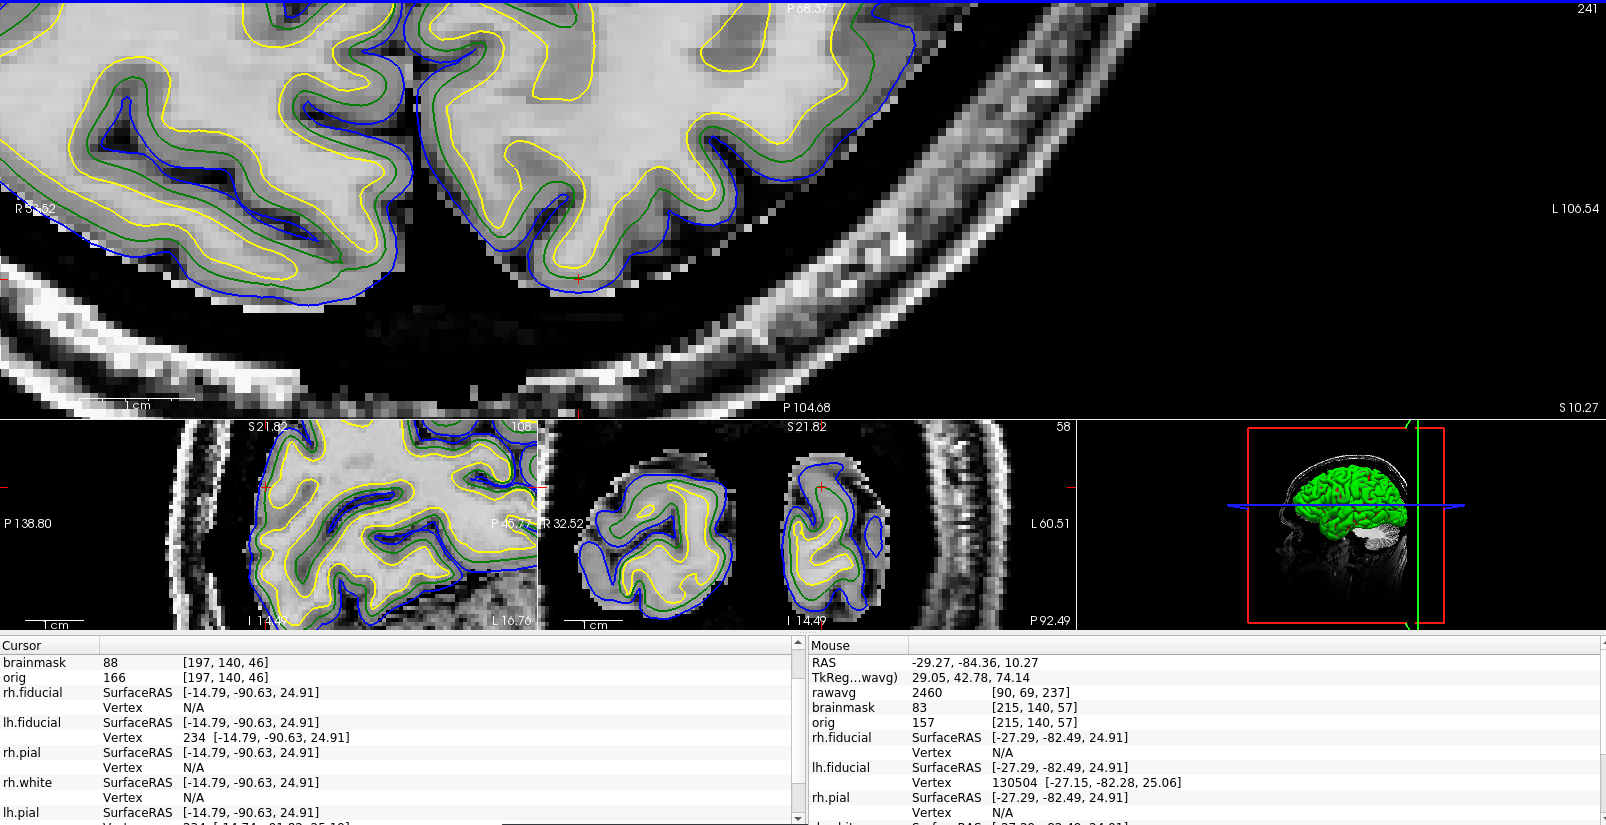

In [19]:
print("pRF location in whole-brain experiment (session 1)")
Image(filename="imgs/234.png")

### Where is target vertex in partial FOV experiment

In [29]:
sub = utils.CollectSubject("sub-003", cx_dir=opj(base_dir, 'derivatives', 'pycortex', 'sub-003'))
vert = sub.return_target_vertex(hemi='lh')
pars = sub.return_prf_params(hemi='lh')
print(f"Target vertex in whole-brain experiment: {vert}")
print(f"With parameters: {pars}")

Target vertex in whole-brain experiment: 646
With parameters: [1.4106846055019346, -1.9416407864998737, 0.4388850415512466, 1.5524366972385906e-05, -0.2958866655826568, 0.7815219759941101]


In whole brain experiment, pRF vox = 646
In partial FOV experiment, pRF vox = 134221


array([ 1.411, -1.942,  0.439,  0.009, -0.282,  0.271])

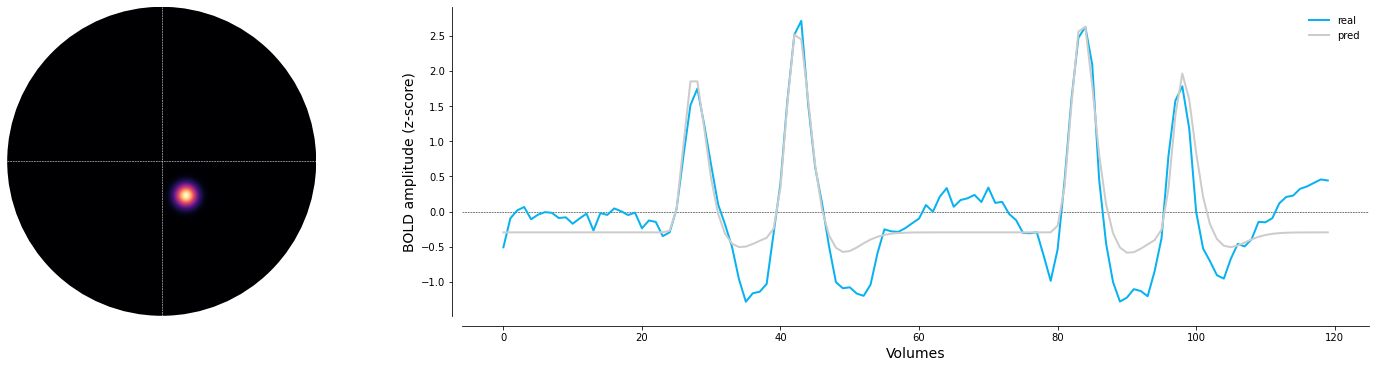

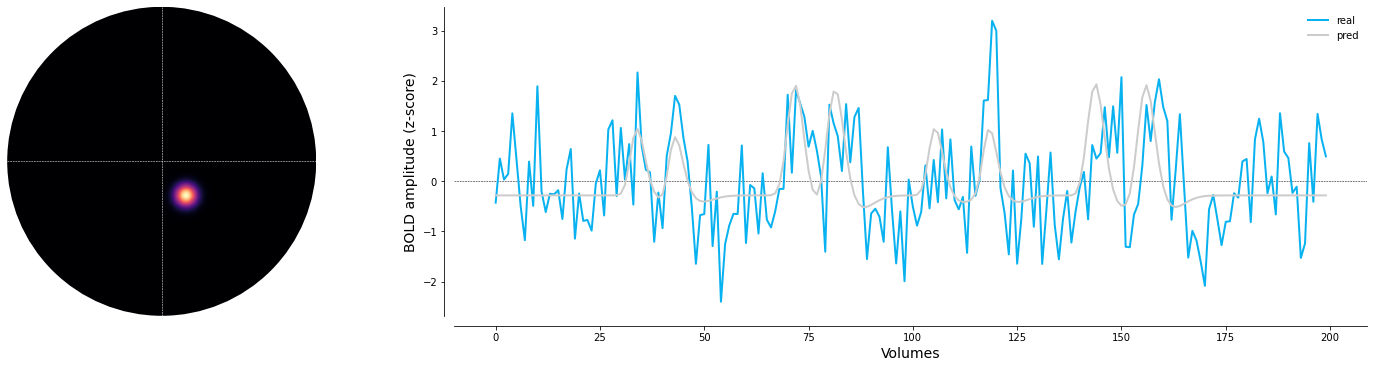

In [35]:
# plot whole-brain vertex
print(f"In whole brain experiment, pRF vox = {vert}")
modelling2.plot_vox(vox_nr=vert, stage='grid')

# find similar pRFs in partial FOV experiment
idc_similar_prfs = prf.find_most_similar_prf(pars, modelling.gauss_grid, r2_thresh=0)

# find the one with the highest r2
idx_max_r2 = utils.find_max_val(modelling.gauss_grid[idc_similar_prfs][:,-1])[0]

# plot
print(f"In partial FOV experiment, pRF vox = {idc_similar_prfs[idx_max_r2]}")
modelling.plot_vox(vox_nr=idc_similar_prfs[idx_max_r2], stage='grid')

target pRF location in whole-brain experiment (session 1)


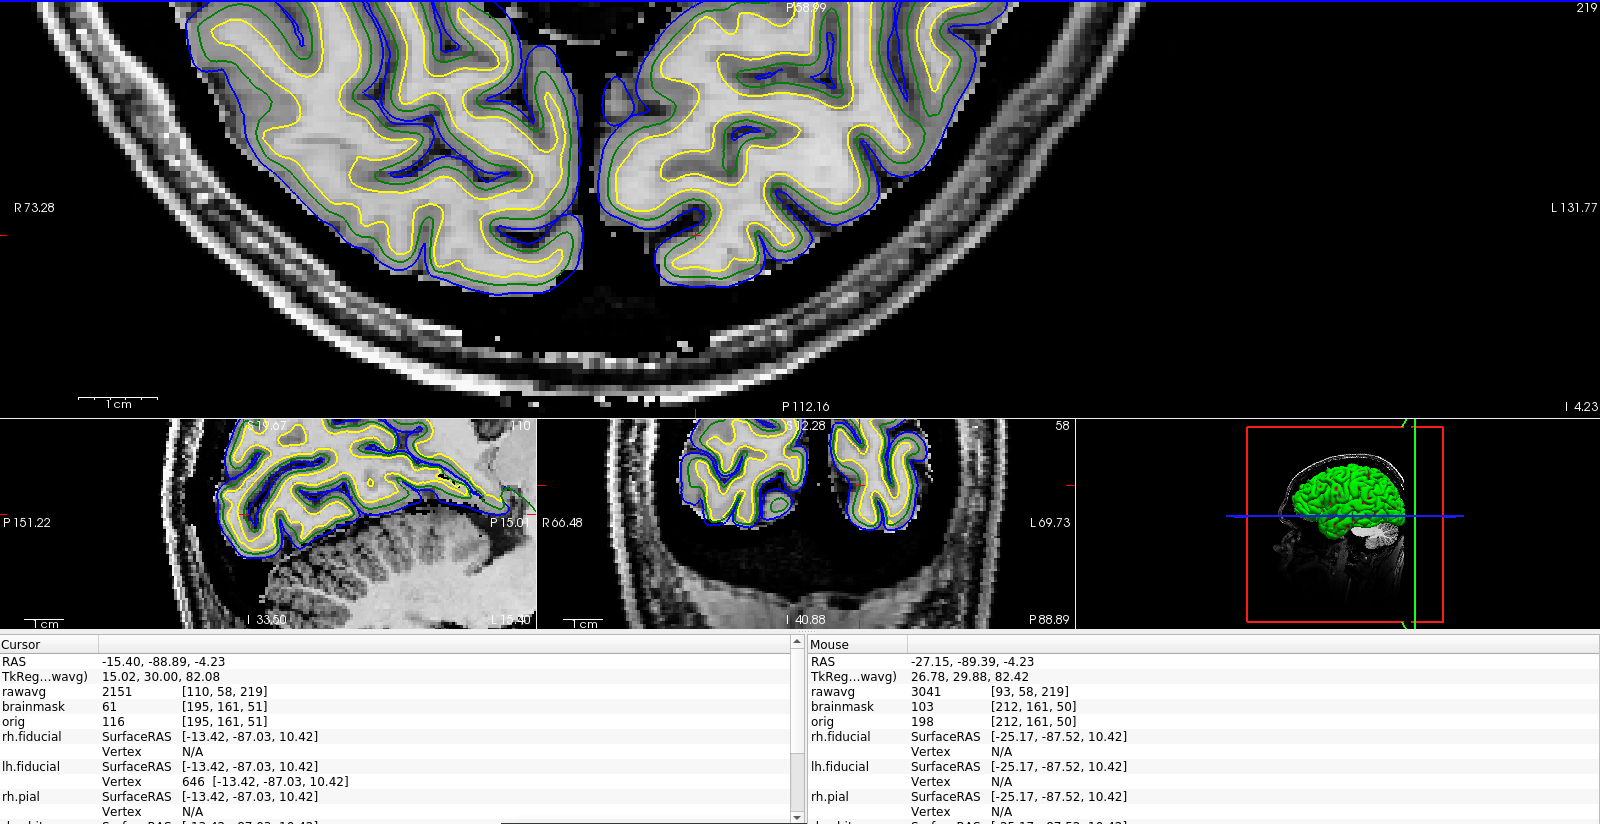

In [36]:
print("target pRF location in whole-brain experiment (session 1)")
Image(filename="imgs/646.png")

similar pRF as target pRF in partial FOV experiment


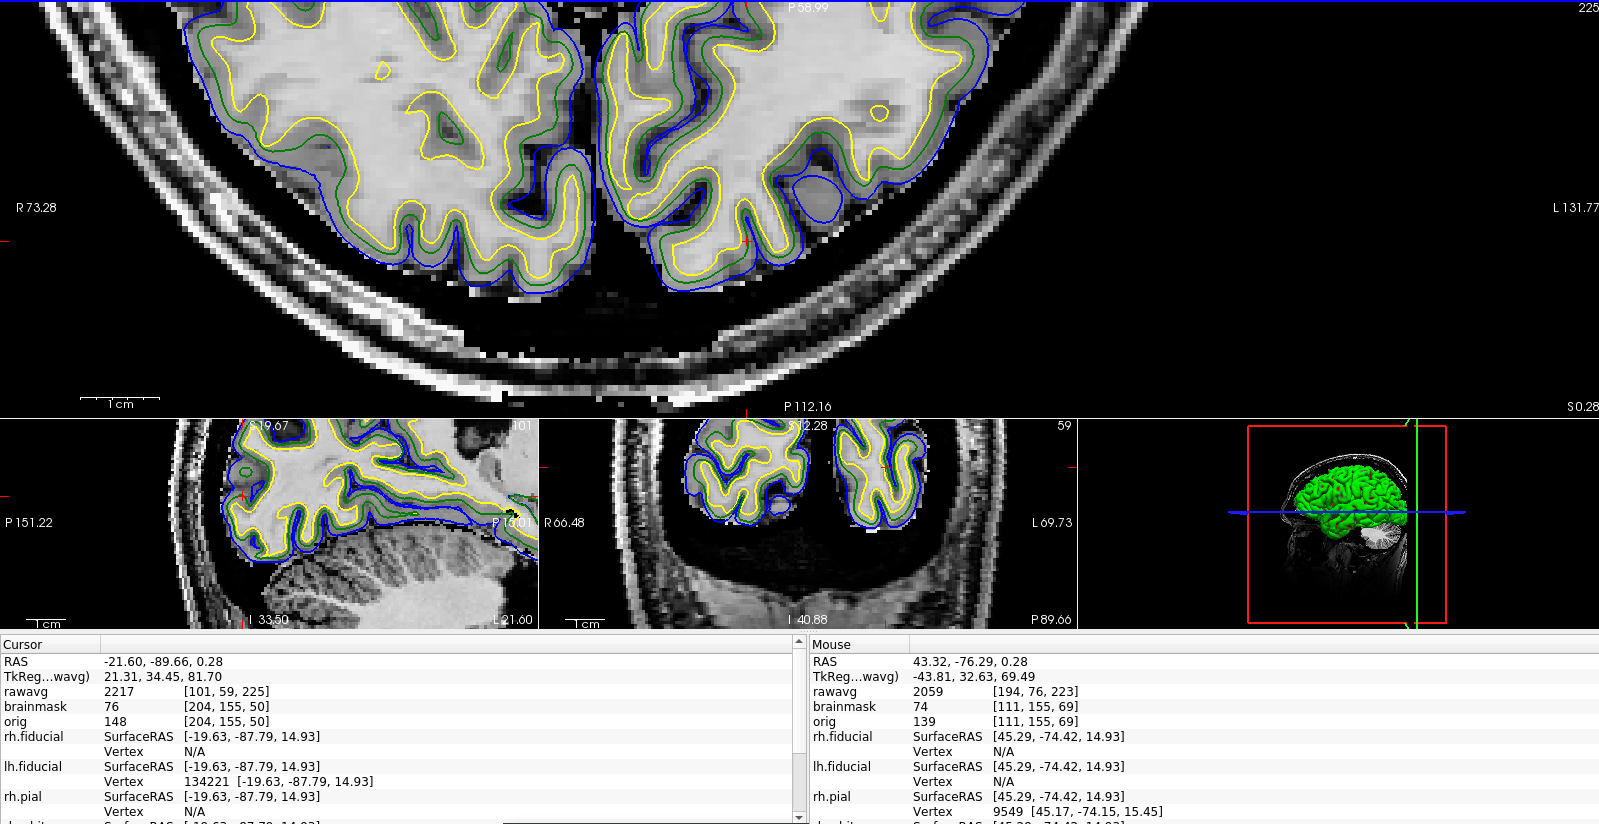

In [37]:
print("similar pRF as target pRF in partial FOV experiment")
Image(filename="imgs/134221.png")